# Analyse MD simulation of ice

In [1]:
from watermodel import *

In [2]:
temp = 100
ice_type = 'XI'
n_waters = 16

# path = ''
path = '/group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/'
info = f'ice{ice_type}_T{temp}_N{n_waters}'
model = WaterModel.load_from_json(f'{path}model-{info}.json')
data = np.load(f'{path}MDtraj-{info}.npz')
pos = data['pos']
box = data['box']
ene = data['ene']

if model.is_box_orthorombic:
    box_edges = np.diagonal(box.squeeze())
    pos = ((pos/box_edges) % 1) * box_edges #force pbc
else:
    print('WARNING: you are working with a non-orthorombic box')

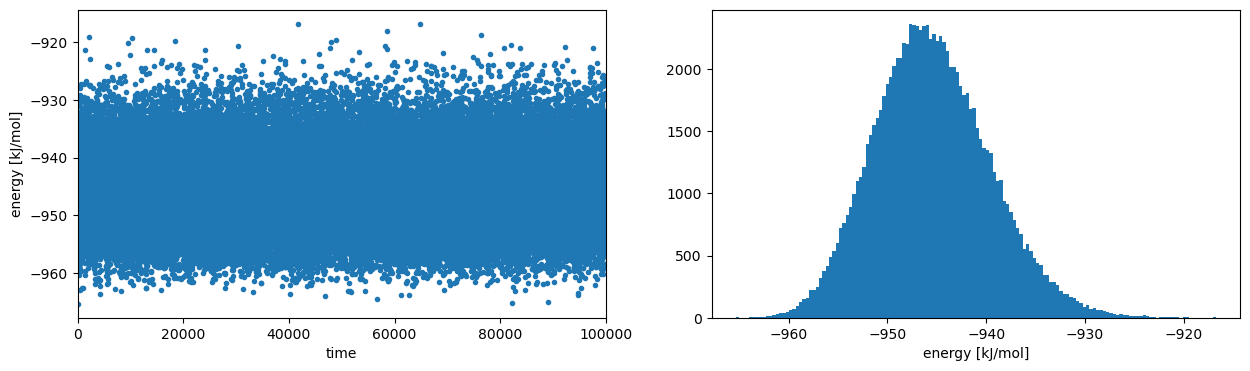

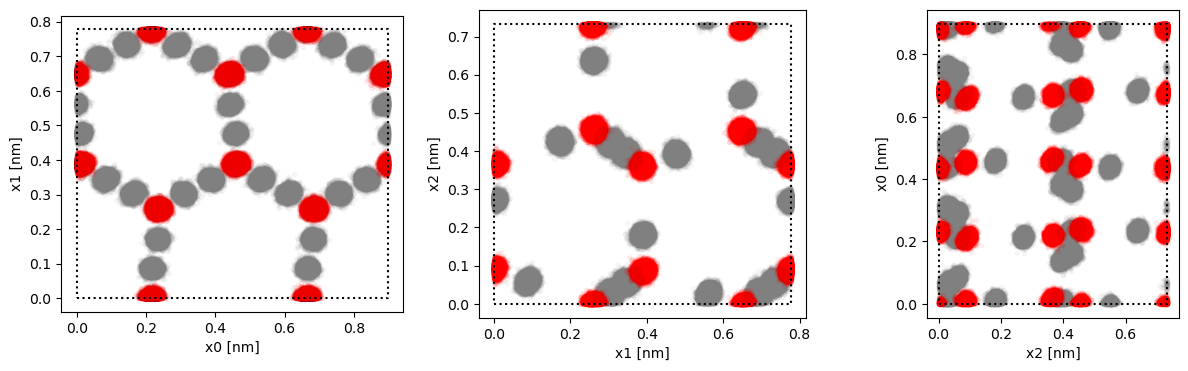

In [3]:
plot_energy(ene)
model.plot_2Dview(pos[::10], box[::10])

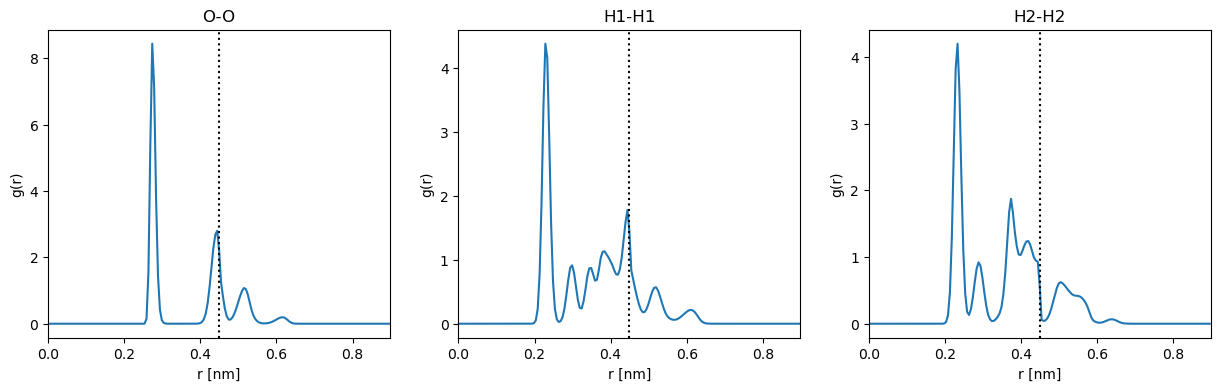

In [4]:
r_range = [0, model.box.max()]

names = ['O', 'H1', 'H2']
n = 1
plt.figure(figsize=(5*len(names), 4))
for a in names:
    plt.subplot(1, len(names), n)
    
    plt.title(f'{a}-{a}')
    model.plot_rdf(pos, r_range=r_range, selection=f'name == {a}')
    plt.axvline(model.box.max()/2, ls=':', c='k')
    n += 1
    
plt.show()

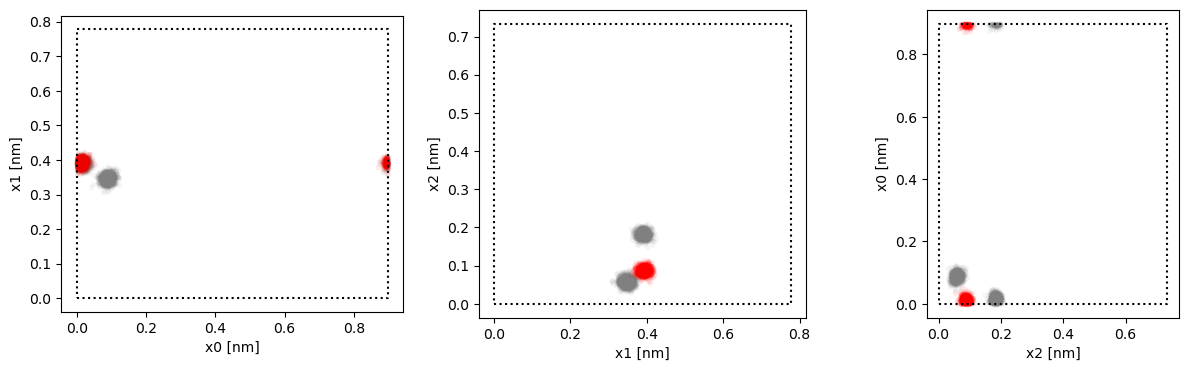

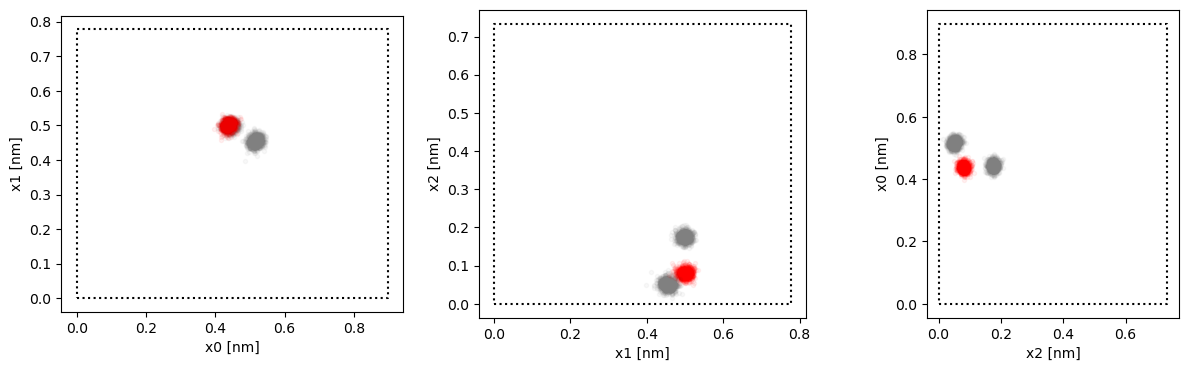

In [5]:
i = model.n_sites * 8
model.plot_2Dview(pos[-1000:,i:i+4], box)
# plot_2Dview(pos[:1000,i:i+4], box)

shift = (pos[-100:,0] - pos[:100,4*4]).mean(axis=0)
shifted_pos = (((pos-shift)/box_edges) % 1)*box_edges
model.plot_2Dview(shifted_pos[:1000,i:i+4], box)
plt.show()

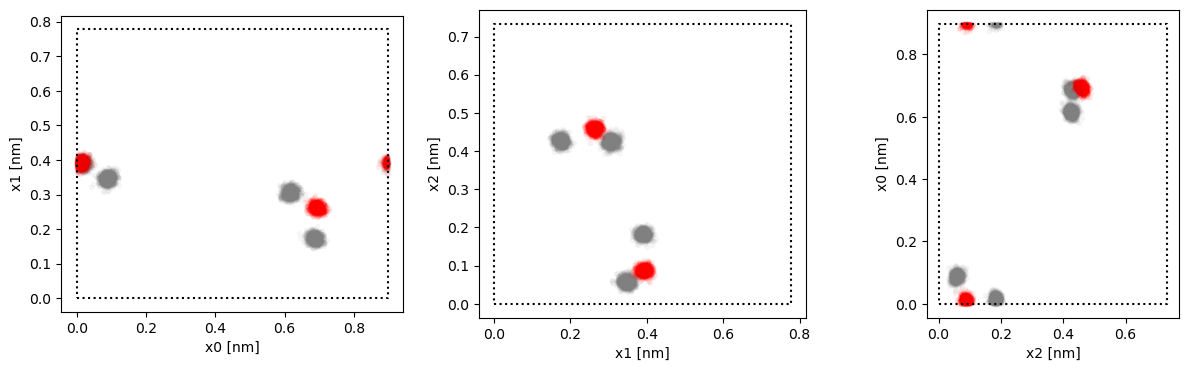

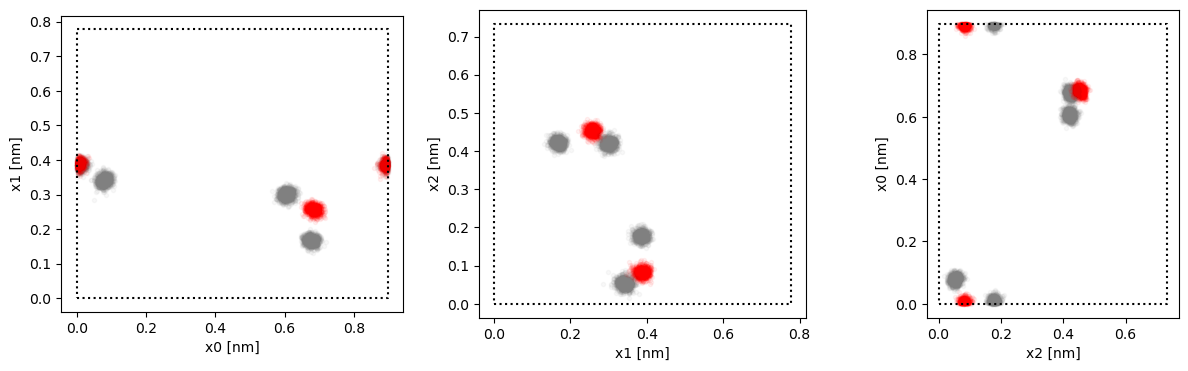

In [7]:
model.plot_2Dview(pos[-1000:,i-4:i+4], box)
model.plot_2Dview(pos[:1000,i-4:i+4], box)